In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *
import utils.vision_transformer as VT

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

# Raw Data

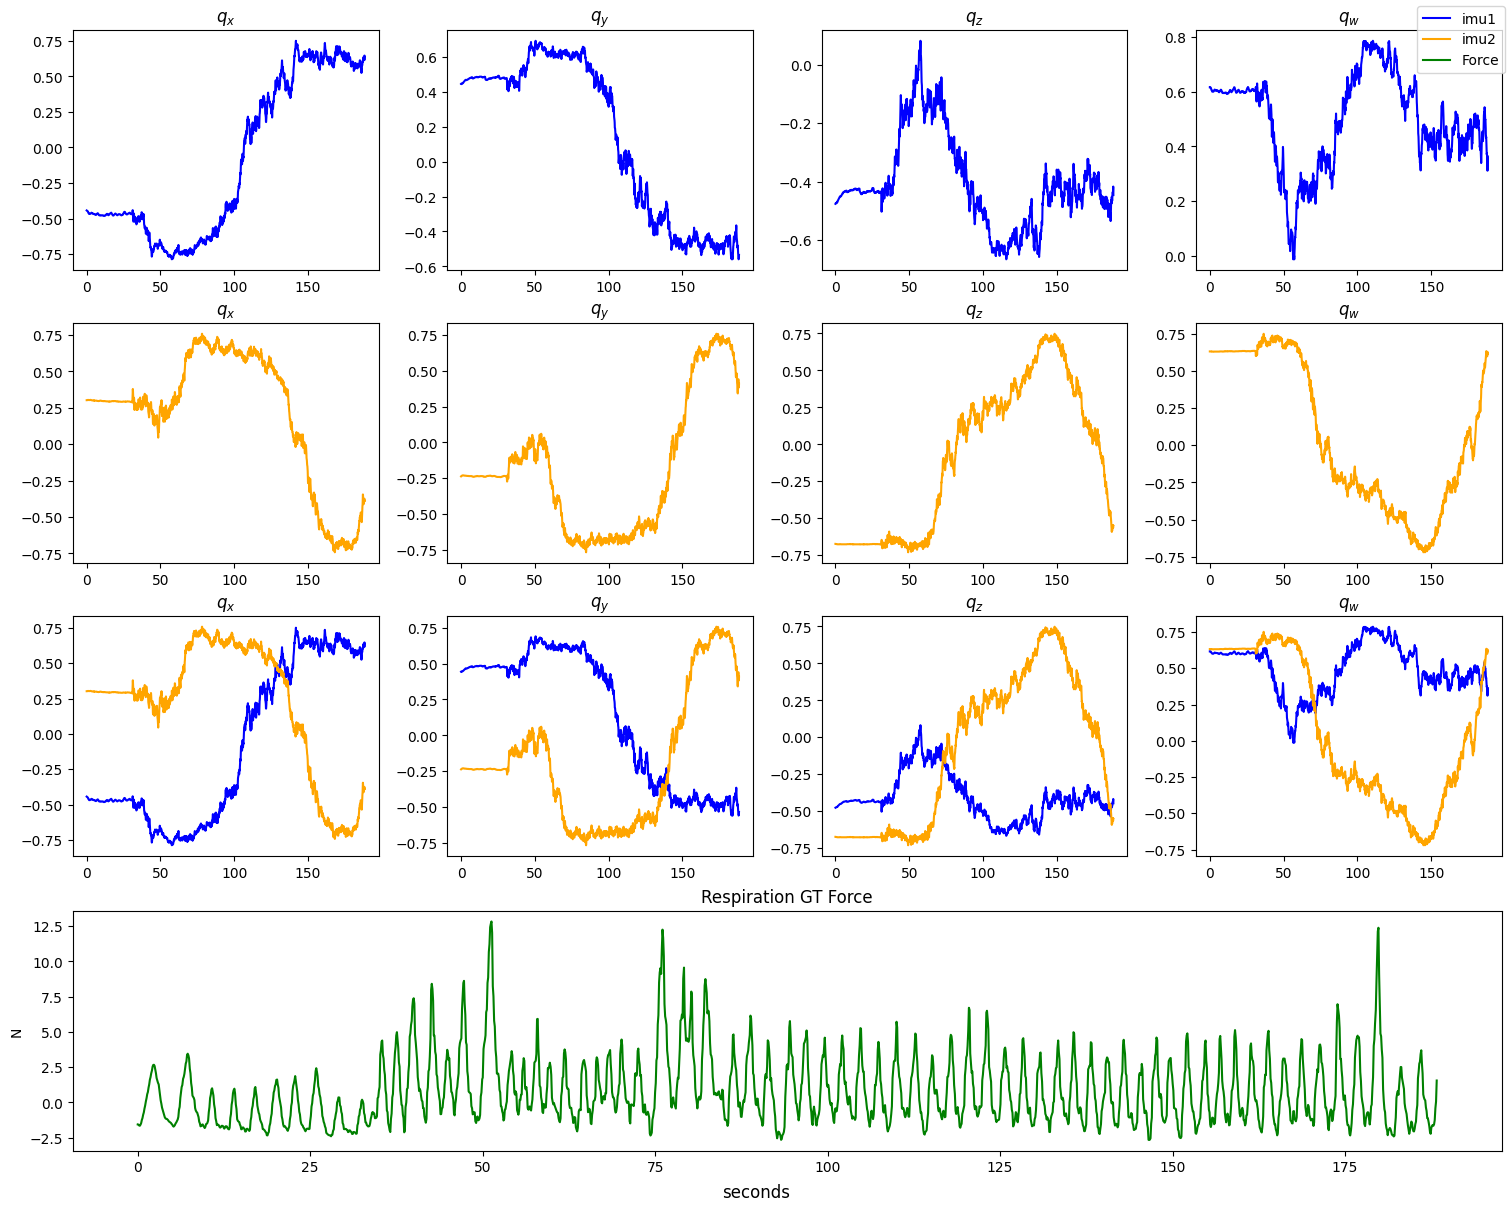

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

person = 'm7'
action_name = "walk_0621_0422"
file_path = f'./data/all/{person}/{action_name}.csv'

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 278/300


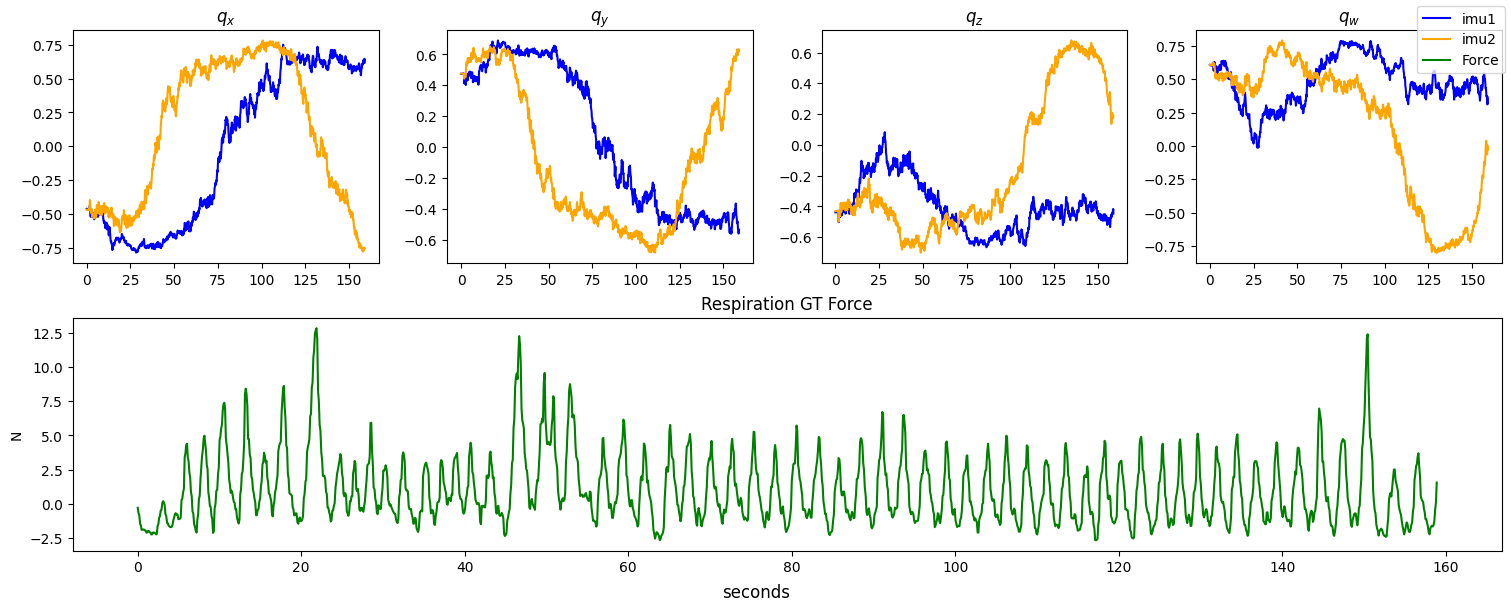

In [3]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned[still_pt+start_pt:], overlap=True, overlap_only=True, show_gt=True)

## Compute Model Parameters (Spectrogram Shape)

In [4]:
# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True
byCol=True
features = ['Q', 'omega', 'omega_l2', 'ANC']

spectrograms_file, gts_file, times_file = prepare_file(file_path, features=features, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1, byCol=byCol)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 278/300
----------------------------
sepctrograms:(22, 32, 65, 3)
gt:(22, 1)
times:(22, 1)


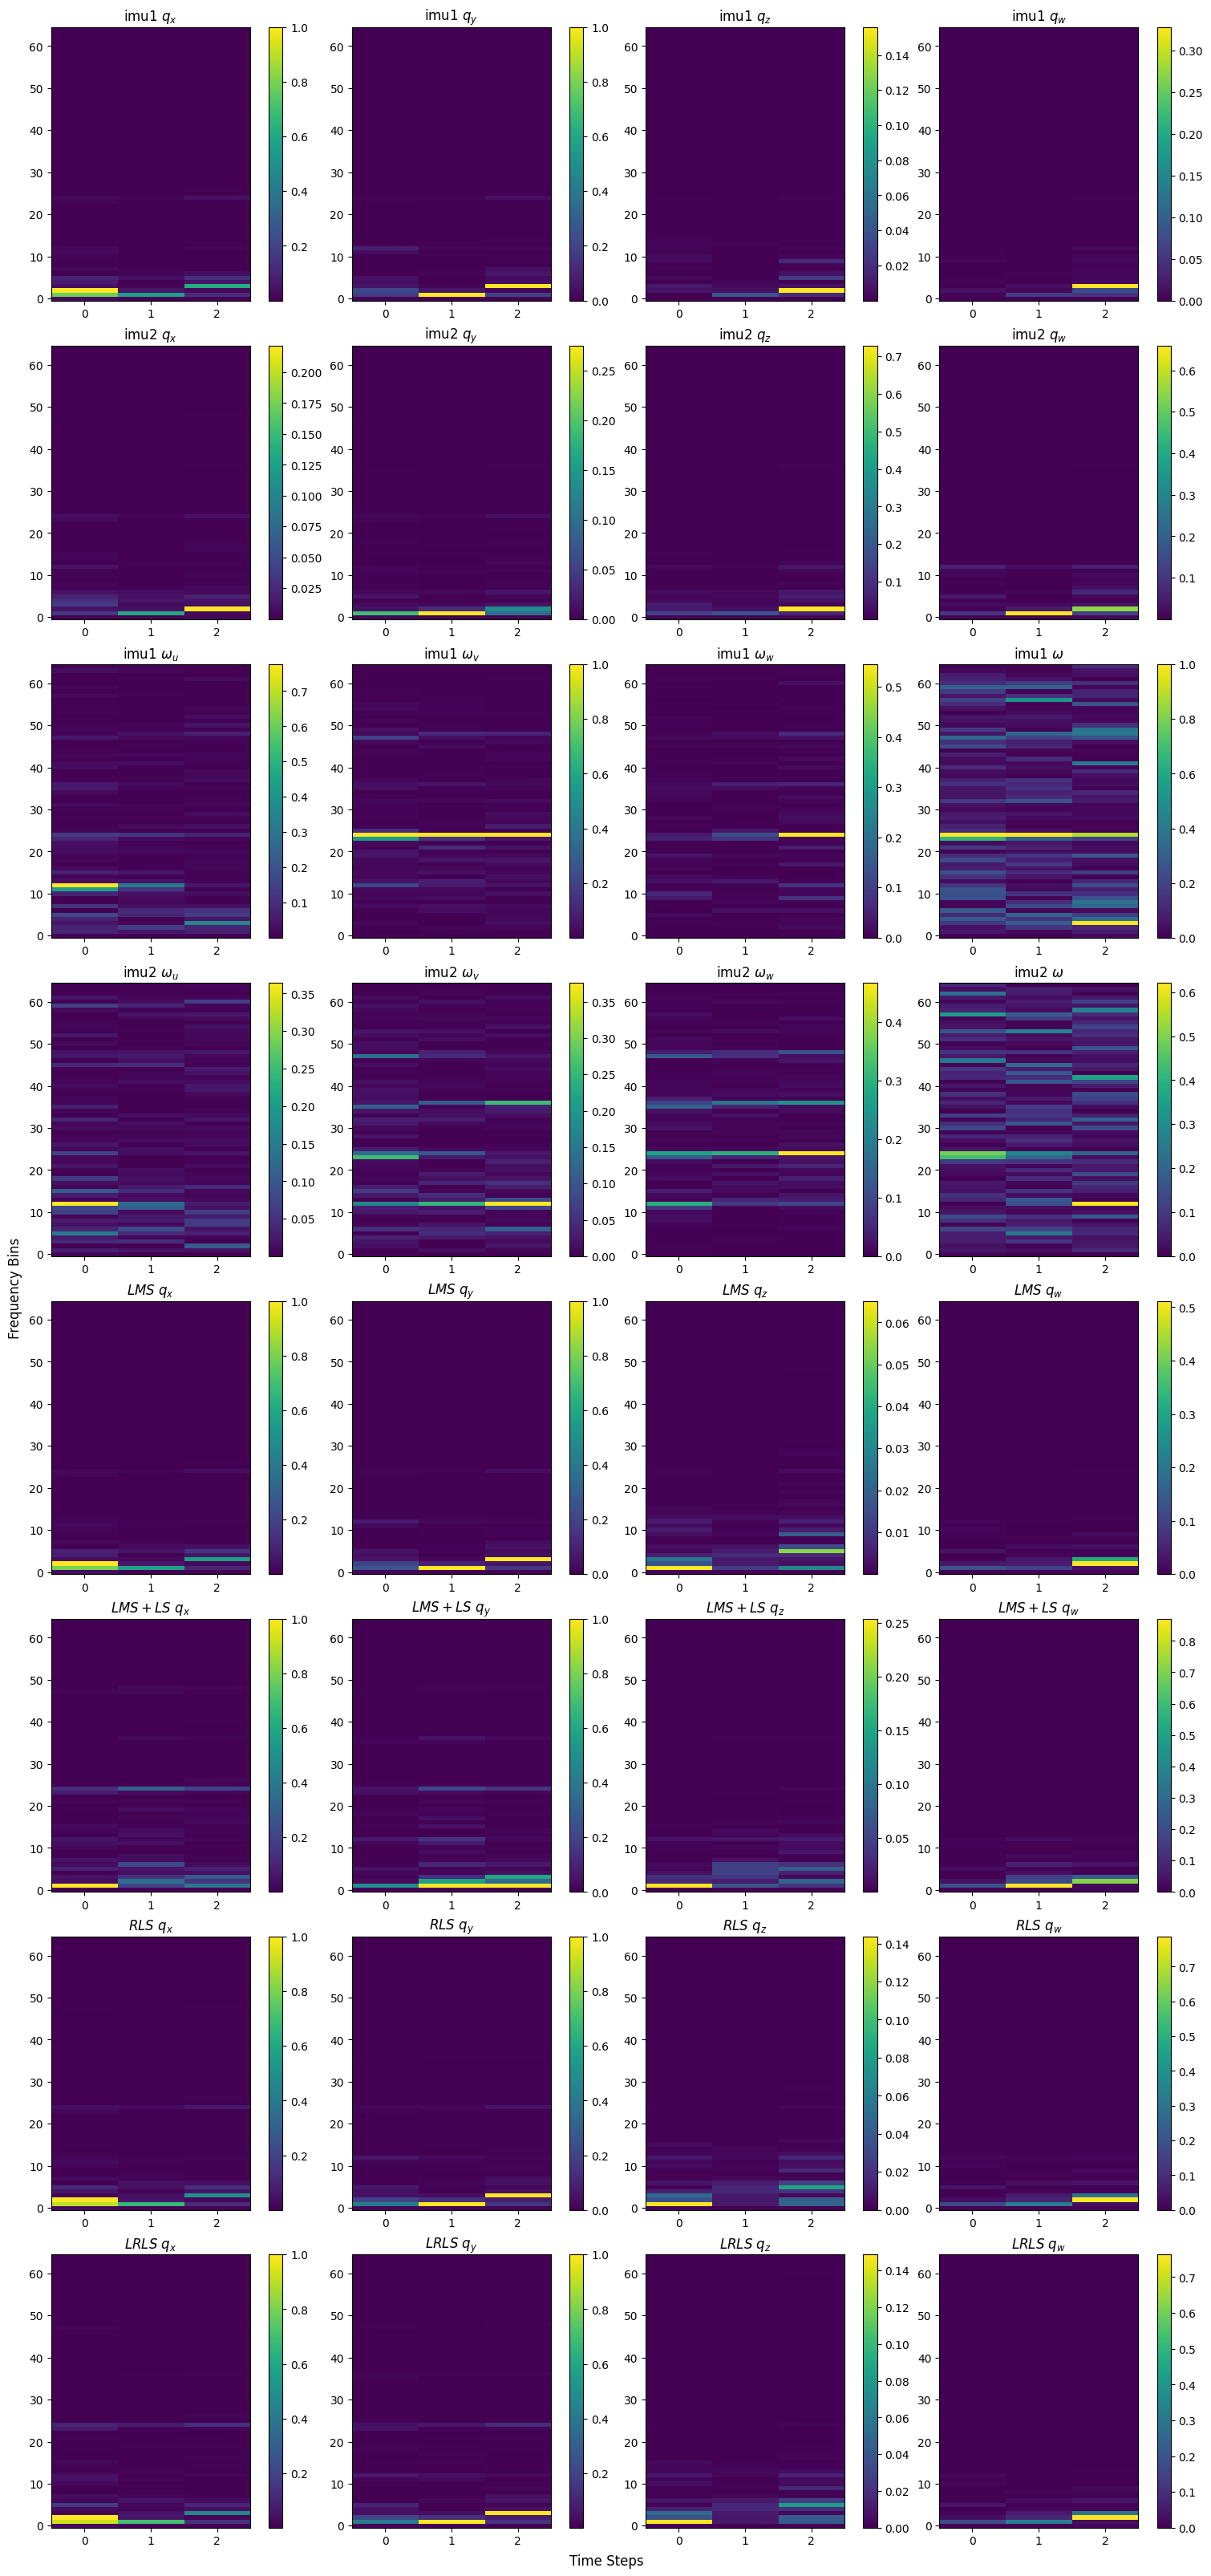

In [5]:
# show one spectrogram
plot_spectrogram(spectrograms_file[12], features=features)

In [6]:
torch.cuda.is_available()

True

## Testing Model

In [7]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "17P"
test_set=['m2', 'm5', 'm7', 'w1', 'w4']
features=['Q', 'omega', 'omega_l2', 'ANC']

dataset = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}.pkl'), 'rb'))
_, _, input_test, gt_test = split_dataset(dataset, test_set=test_set, features=features)

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

Testing data......
Testing shape: (458, 32, 65, 3)


In [8]:
# Test one file
person = 'm7'
action_name = "walk_0621_0422"
path_file = f'./data/all/{person}/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, features=features, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 278/300
----------------------------
sepctrograms:(22, 32, 65, 3)
gt:(22, 1)
times:(22, 1)


In [9]:
# Load models
# 2-D spectrogram
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_name = ['MLP_17P_32', 'CNN_17P_32', 'VT_17P_32_emb128_mlp256_nl2'] # VT_17P_32_s
models_name_show = ["MLP", "CNN", "ViT"]

# models_name = ['MLP_17P_32', 'CNN_17P_32', 'VT_17P_32_emt2']
# models_name_show = ["f1&2+MLP", "f1&2+CNN", "f1&2+ViT"]

models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          VT.ViTRegression(in_channels=num_channels, patch_size=(3, 3), emb_dim=128, mlp_dim=256, num_heads=4, num_layers=2, device=device, load=True, model_name='VT_17P_32_emb128_mlp256_nl2'),]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_17P_32 Evaluation Results - MSE Loss: 20.6302, L1 Loss: 3.0907 1/min
CNN_17P_32 Evaluation Results - MSE Loss: 17.2115, L1 Loss: 3.0698 1/min
VT_17P_32_emb128_mlp256_nl2 Evaluation Results - MSE Loss: 17.7697, L1 Loss: 2.9306 1/min


MLP Evaluation Results - MSE Loss: 0.0114, L1 Loss: 5.3786 1/min, R²:-2.3960
CNN Evaluation Results - MSE Loss: 0.0036, L1 Loss: 2.7228 1/min, R²:-0.0762
ViT Evaluation Results - MSE Loss: 0.0061, L1 Loss: 4.1803 1/min, R²:-0.8101


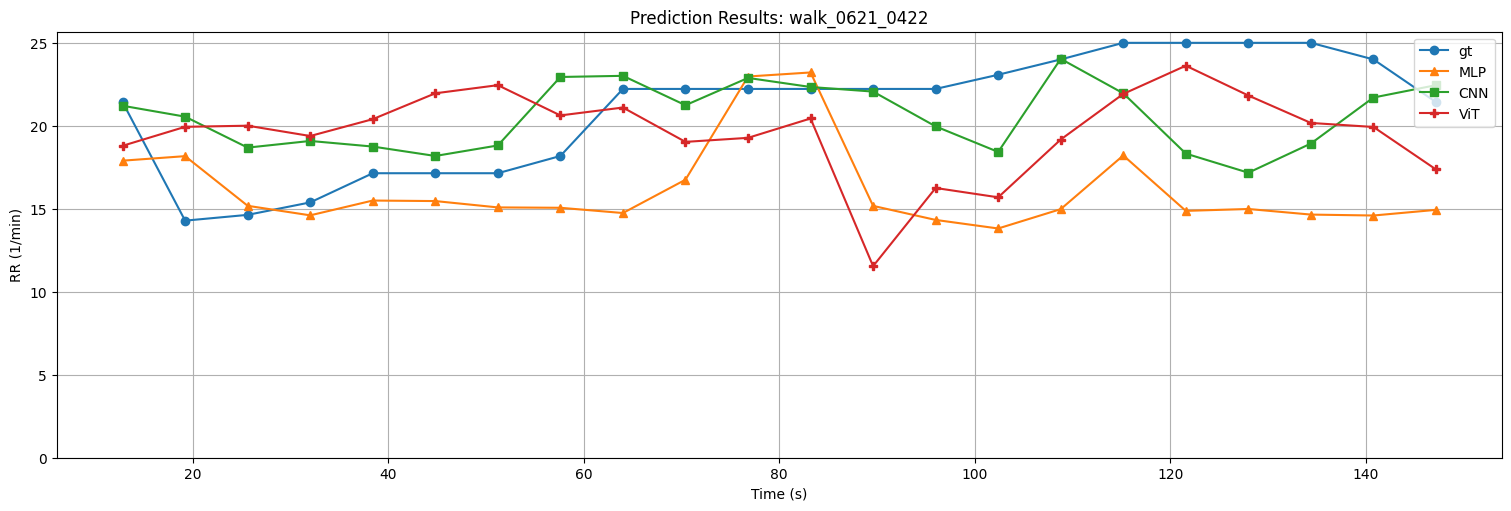

In [10]:
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=models_name_show, gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [11]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "17P"
test_set=['m2', 'm5', 'm7', 'w1', 'w4']
features=['Q', 'omega', 'omega_l2', 'ANC']

dataset = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}.pkl'), 'rb'))
_, _, input_test, gt_test = split_dataset(dataset, test_set=test_set, features=features, ByAction=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

action_order = ['sit', 'stand', 'walk', 'run']
input_test = {k : input_test[k] for k in action_order}
gt_test = {k : gt_test[k] for k in action_order}
print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk
action: run


MLP
sit - MSE Loss: 0.0010, L1 Loss: 1.2005 1/min
stand - MSE Loss: 0.0014, L1 Loss: 1.5476 1/min
walk - MSE Loss: 0.0151, L1 Loss: 5.7907 1/min
run - MSE Loss: 0.0055, L1 Loss: 3.7208 1/min

CNN
sit - MSE Loss: 0.0019, L1 Loss: 1.7291 1/min
stand - MSE Loss: 0.0022, L1 Loss: 2.1221 1/min
walk - MSE Loss: 0.0114, L1 Loss: 5.4288 1/min
run - MSE Loss: 0.0038, L1 Loss: 3.0091 1/min

ViT
sit - MSE Loss: 0.0021, L1 Loss: 1.8012 1/min
stand - MSE Loss: 0.0016, L1 Loss: 1.7912 1/min
walk - MSE Loss: 0.0117, L1 Loss: 5.0384 1/min
run - MSE Loss: 0.0044, L1 Loss: 3.0692 1/min



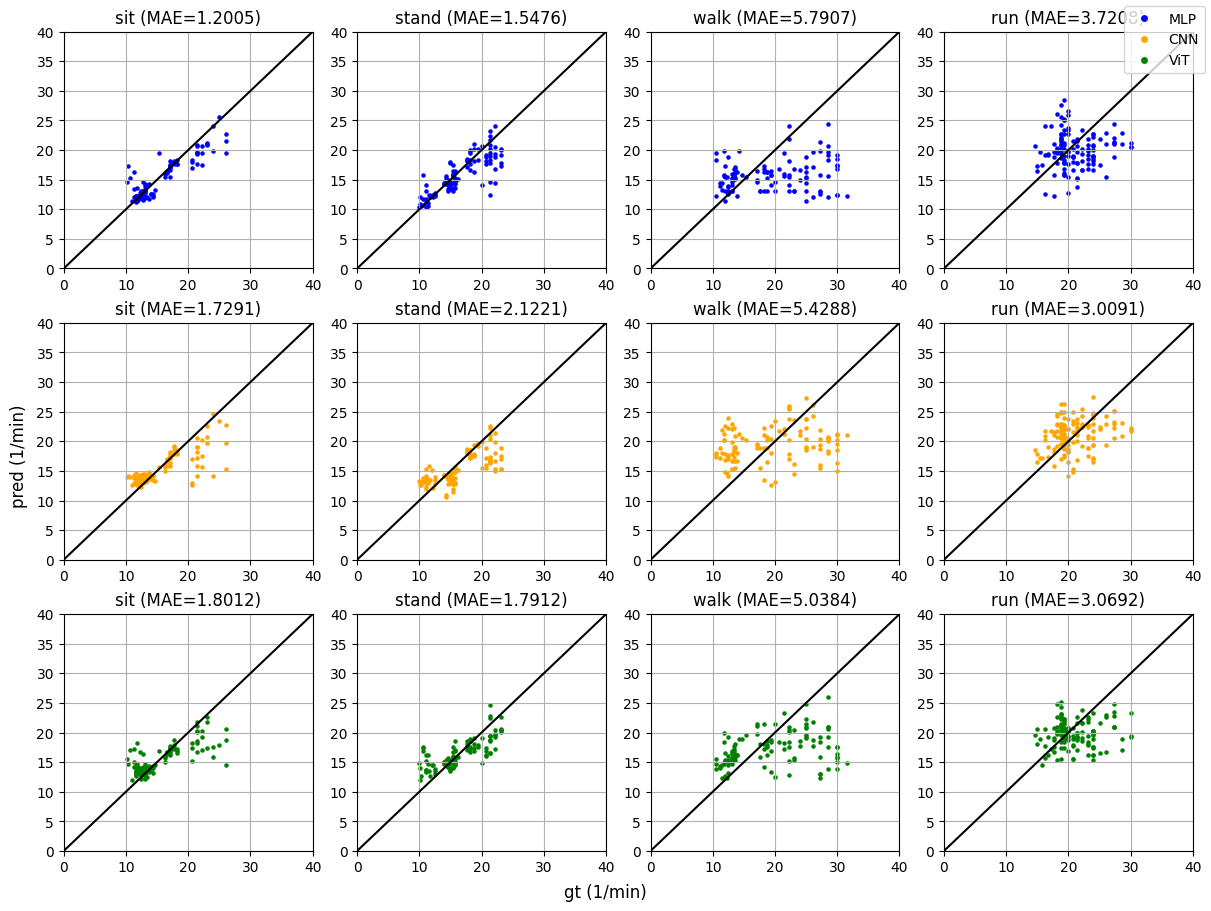

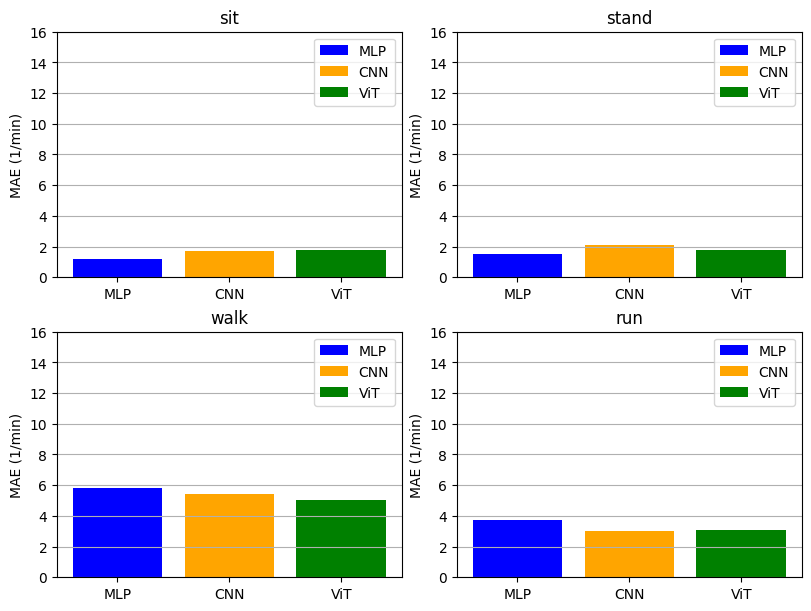

In [12]:
evaluate_models_action(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)

MLP
sit - MSE Loss: 0.0010, L1 Loss: 1.2005 1/min E%: 7.7286%
stand - MSE Loss: 0.0014, L1 Loss: 1.5476 1/min E%: 8.8393%
walk - MSE Loss: 0.0151, L1 Loss: 5.7907 1/min E%: 27.4070%
run - MSE Loss: 0.0055, L1 Loss: 3.7208 1/min E%: 17.5524%

CNN
sit - MSE Loss: 0.0019, L1 Loss: 1.7291 1/min E%: 10.6918%
stand - MSE Loss: 0.0022, L1 Loss: 2.1221 1/min E%: 12.9261%
walk - MSE Loss: 0.0114, L1 Loss: 5.4288 1/min E%: 30.9736%
run - MSE Loss: 0.0038, L1 Loss: 3.0091 1/min E%: 14.4066%

ViT
sit - MSE Loss: 0.0021, L1 Loss: 1.8012 1/min E%: 11.6053%
stand - MSE Loss: 0.0016, L1 Loss: 1.7912 1/min E%: 11.8992%
walk - MSE Loss: 0.0117, L1 Loss: 5.0384 1/min E%: 24.7698%
run - MSE Loss: 0.0044, L1 Loss: 3.0692 1/min E%: 14.0663%



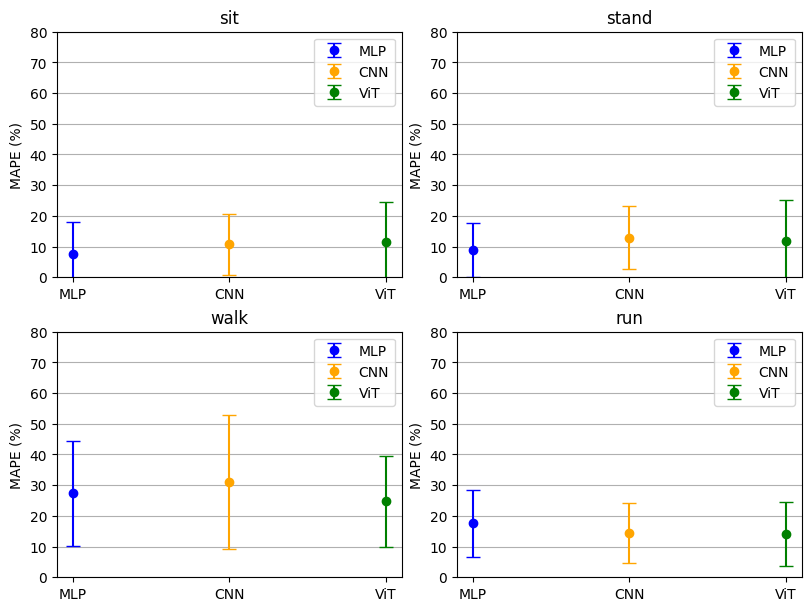

In [13]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=models_name_show, device=device, visualize=True)